# Calculate the Cluster Biosimilarity Matrix

*Additional figures for the revision*

For a given set of measurements, This Notebook calculates the similarity to all defined clusters.  
and displays the result as a matrix.


In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os.path as op

from typing import Iterable, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns

from IPython.display import HTML, display 

# from tqdm.notebook import tqdm
import ipywidgets as ipyw
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from jupy_tools import plt_style, cpa
from jupy_tools import utils as u
from jupy_tools.utils import info
u.timestamp()

Timestamp: 13-Mar-2023 11:03:00


In [8]:
CONFIGS = {
    "dfo": [
        "247256:03:02_02.00", "247256:01:06_03.00", "247256:03:04_06.00", "247256:03:04_10.00", "247256:01:04_30.00",
    ], 
    "pi103": ["381944:02:09_02.00", "381944:01:12_03.00", "381944:01:11_10.00",]
}

## Load Data Set

In [3]:
ds_refs = u.read_tsv("../output/ds_refs_sim_to_clusters.tsv")

read_tsv                           : [    3572 / 603 ] 


In [6]:
clusters_short = cpa.get_func_cluster_names()
clusters_long = [f"Cluster_{cl}" for cl in clusters_short]
renames = {cl_long: cl_short for cl_long, cl_short in zip(clusters_long, clusters_short)}

Some specific Renames for nicer legends:

In [7]:
renames["Cluster_AKT_PI3K_MTOR"] = "AKT/PI3K/MTOR"
renames["Cluster_DNA_Synth"] = "DNA Synth"
renames["Cluster_Na_K-ATPase"] = "Na+/K+-ATPase"
renames["Cluster_Protein_Synth"] = "Protein Synth"
renames["Cluster_Pyrimidine_Synth"] = "Pyrimid. Synth"
renames


{'Cluster_AKT_PI3K_MTOR': 'AKT/PI3K/MTOR',
 'Cluster_Aurora': 'Aurora',
 'Cluster_BET': 'BET',
 'Cluster_DNA_Synth': 'DNA Synth',
 'Cluster_HDAC': 'HDAC',
 'Cluster_HSP90': 'HSP90',
 'Cluster_LCH': 'LCH',
 'Cluster_Na_K-ATPase': 'Na+/K+-ATPase',
 'Cluster_Protein_Synth': 'Protein Synth',
 'Cluster_Pyrimidine_Synth': 'Pyrimid. Synth',
 'Cluster_Tubulin': 'Tubulin',
 'Cluster_Uncoupler': 'Uncoupler'}

5


,Well_Id,Cluster_AKT_PI3K_MTOR,Cluster_Aurora,Cluster_BET,Cluster_DNA_Synth,Cluster_HDAC,Cluster_HSP90,Cluster_LCH,Cluster_Na_K-ATPase,Cluster_Protein_Synth,Cluster_Pyrimidine_Synth,Cluster_Tubulin,Cluster_Uncoupler
0,247256:03:02_02.00,21.3,32.1,0.0,77.8,0.0,0.0,0.0,0.0,0.0,73.2,0.0,0.0
1,247256:01:06_03.00,38.3,19.4,0.0,91.8,0.0,0.0,0.0,0.0,0.0,81.8,0.0,0.0
2,247256:03:04_06.00,49.0,0.0,0.0,93.7,0.0,0.0,0.0,0.0,0.0,74.7,0.0,0.0
3,247256:03:04_10.00,51.4,4.4,0.0,93.3,0.0,0.0,0.0,0.0,0.0,74.9,0.0,0.0
4,247256:01:04_30.00,44.2,22.8,0.0,92.6,0.0,0.0,0.0,0.0,0.0,73.6,0.0,0.0


Text(127.8888888888889, 0.5, '')

Text(0.5, 1.0, 'Cluster Biosimilaritites')

3


,Well_Id,Cluster_AKT_PI3K_MTOR,Cluster_Aurora,Cluster_BET,Cluster_DNA_Synth,Cluster_HDAC,Cluster_HSP90,Cluster_LCH,Cluster_Na_K-ATPase,Cluster_Protein_Synth,Cluster_Pyrimidine_Synth,Cluster_Tubulin,Cluster_Uncoupler
0,381944:02:09_02.00,89.5,0.0,0.0,64.5,0.0,25.1,7.6,0.0,0.0,51.3,0.0,35.6
1,381944:01:12_03.00,80.1,0.0,15.2,18.0,19.8,23.1,42.4,0.1,1.9,15.5,9.4,56.8
2,381944:01:11_10.00,9.2,0.0,65.9,0.0,64.8,11.3,86.6,30.7,21.1,0.0,61.4,58.7


Text(127.8888888888889, 0.5, '')

Text(0.5, 1.0, 'Cluster Biosimilaritites')

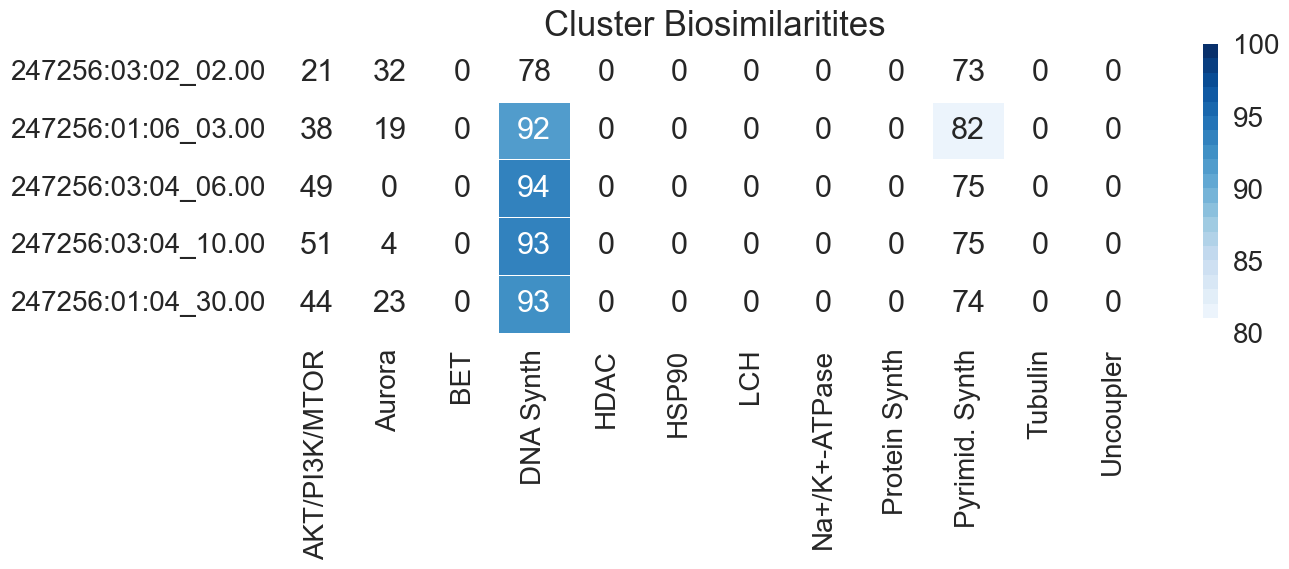

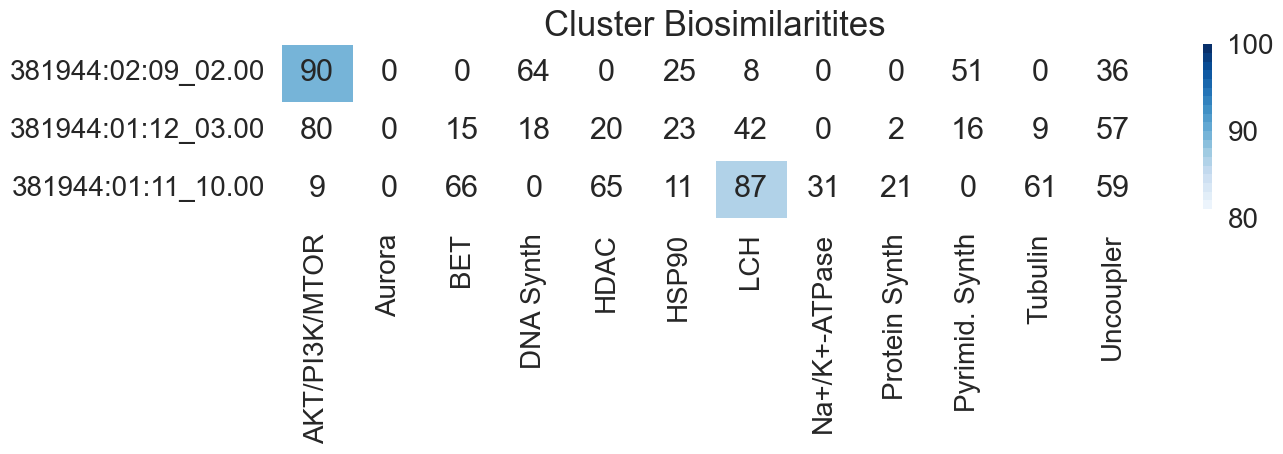

In [9]:
# "Tubulin", "HDAC", "Protein Synth", "HTH"
for config in CONFIGS:
    w_ids = CONFIGS[config]
    height = 0.75 * len(w_ids)
    labels = w_ids
    blues = cm.get_cmap("Blues", 20)
    white_blue = blues(np.linspace(0, 1, 20))
    white_blue[0, :] = 1
    wb_cm = ListedColormap(white_blue)
    columns = ["Well_Id"]
    columns.extend(clusters_long)
    df_cpds = ds_refs[ds_refs["Well_Id"].isin(w_ids)].copy()
    # Sort the filtered dataframe according to the Well_Id input list.
    # StackOverflow: https://stackoverflow.com/a/58622999
    # This is needed to have the correct order in the heatmap later on:
    df_cpds = df_cpds.set_index('Well_Id').loc[w_ids].reset_index()
    print(len(df_cpds))
    df_cpds["Well_Id_org"] = df_cpds["Well_Id"]
    df_cpds["Well_Id"] = labels
    df_biosim = df_cpds[columns].copy()
    df_biosim
    # other color schems considered: 1 - afmhot_r; 2 - binary; 
    tmp = df_biosim.copy()
    tmp = tmp.rename(columns=renames)
    tmp.set_index("Well_Id", inplace=True)
    f, ax = plt.subplots(figsize=(14, height))
    hm = sns.heatmap(tmp, annot=True, fmt=".0f", linewidths=.5, annot_kws={"size": 22}, cmap=wb_cm, vmin=80.0, vmax=100.0, ax=ax);
    # hm.invert_yaxis()
    hm.set_ylabel("")
    hm.set_title("Cluster Biosimilaritites")
    fig = hm.get_figure()
    plt.savefig(f"plots/ex_{config.lower()}_biosim.png", bbox_inches='tight')
    plt.savefig(f"plots/ex_{config.lower()}_biosim.svg", bbox_inches='tight')